In [1]:
! pip install 'cebra[dev,demos]' 

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: No such file or directory
/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/bin/pip: line 2: exec: /Users/brian.gitahi/Desktop/AIND/CEBRA Analysis/CEBRA13/cebraenv/bin/python: cannot execute: No such file or directory


In [2]:
import sys
import os # my addtion

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import cebra.datasets
from cebra import CEBRA
import torch

from sklearn import manifold
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score


from matplotlib.collections import LineCollection
import pandas as pd
import d_library as dl

/Users/brian.gitahi/Desktop/AIND/CEBRA/CEBRA-Analysis/cebraenv/lib/python3.11/site-packages/cebra/datasets/__init__.py:103: UserWarning: Could not initialize one or more datasets: No module named 'h5py'. For using the datasets, consider installing the [datasets] extension via pip.
  warnings.warn(f"Could not initialize one or more datasets: {e}. "


In [3]:
iterations = 2000

In [5]:
# GET THIS FROM A LIBRARY SCRIPT LATER
def base_embed(input, temp=1, dimension=3, lr = 0.0001, d=0.1):

    
    # build CEBRA time model
    model = CEBRA(model_architecture='offset1-model-mse',
                         batch_size=512,
                         learning_rate=int(lr),
                         temperature=int(temp),
                         output_dimension = int(dimension),
                         max_iterations=iterations,
                         distance='euclidean',
                         delta=int(d),
                         conditional='delta',
                         device='cuda_if_available',
                         num_hidden_units=64,
                         verbose=True)

    model.fit(input)
    embedding = model.transform(input)
    return model, embedding

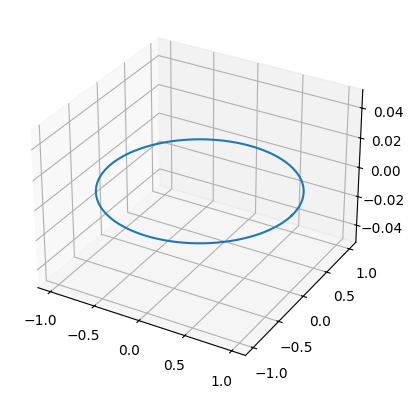

(100, 3)

In [6]:
%matplotlib inline
circle = dl.make_circle()
dl.plot_circle(circle[:,0], circle[:,1])
circle.shape

In [7]:
xyz = dl.make_lorenz()

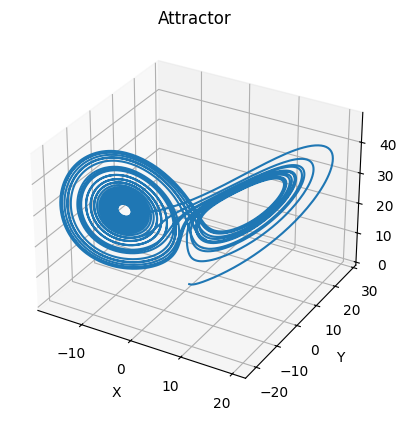

In [8]:
# Plot the Lorenz attractor
dl.plot_lorenz(xyz)

In [9]:
# reshape the lorenz object for use with cebra
lorenz_obj = xyz.reshape(10000,3)
lorenz_obj.shape

(10000, 3)

In [51]:
# ideal model for circle and lorenz inputs
ideal_model, ideal_embedding = base_embed(input=circle, temp=1, dimension=3, lr = 0.1, d=0.1) 
ideal_model_l, ideal_embedding_l = base_embed(input=lorenz_obj, temp=1,dimension=3, lr=0.01, d=1)

  0%|          | 0/2000 [00:00<?, ?it/s]

pos: -1.0000 neg:  7.2213 total:  6.2213 temperature:  1.0000: 100%|██████████| 2000/2000 [00:19<00:00, 104.78it/s]
pos: -0.9999 neg:  7.1472 total:  6.1473 temperature:  1.0000: 100%|██████████| 2000/2000 [00:18<00:00, 110.51it/s]


In [52]:
ideal_embedding.shape

(100, 3)

In [17]:
np.sum(ideal_embedding[0])

-1.619426280260086

In [23]:
cebra.io.reduce(ideal_embedding, ratio=0.99, num_components=3)

4.496403249731884e-15

<Axes3D: title={'center': 'Lorenz Attractor'}>

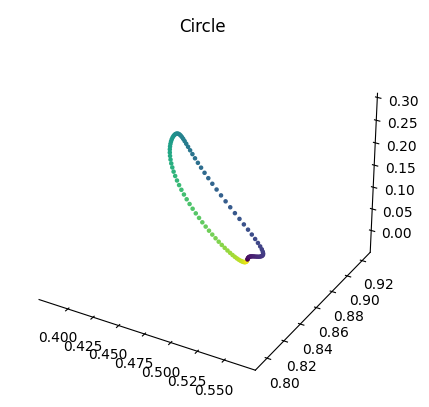

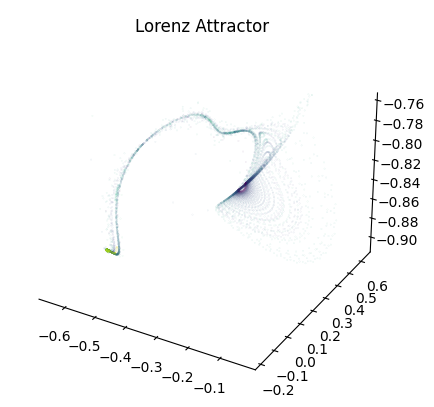

In [53]:
cebra.plot_embedding(ideal_embedding, embedding_labels='time', markersize=5, alpha=1, title='Circle')
cebra.plot_embedding(ideal_embedding_l, embedding_labels='time', markersize=0.001, alpha=1, title='Lorenz Attractor')

Ok, now that we have the outputs of the Models notebook, let's compare the ideal embedding with the top 2 PCs for the Lorenz Attractor. The CEBRA embedding shouldn't be any worse than that

In [27]:
z = StandardScaler().fit_transform(lorenz_obj)

In [31]:
lorenz_obj

array([[ 0.        ,  0.06871424,  0.13505721],
       [ 0.19933923,  0.26183952,  0.32282333],
       [ 0.38254524,  0.44124914,  0.49916826],
       ...,
       [15.88052124, 15.75724579, 15.63623619],
       [15.51752426, 15.4011621 , 15.28719858],
       [15.17568095, 15.06666016, 14.96019082]])

In [30]:
z

array([[-0.36630336, -0.36189327, -0.35761068],
       [-0.35339766, -0.3493899 , -0.34545436],
       [-0.34153646, -0.33777452, -0.33403748],
       ...,
       [ 0.66183982,  0.65381793,  0.64596326],
       [ 0.63833852,  0.63076427,  0.62336595],
       [ 0.61620676,  0.60910785,  0.60219488]])

In [87]:
# make a function that compares the top 2 PCs and the CEBRA embedding

def pc_cebra_comp(object, n_iterations = 1):
    
    # Check if the input array has shape (n, m)
    assert object.shape[1] == 3 , f"Input array must have shape 3 columns"

    # standardize input data to PCA
    pca_obj = StandardScaler().fit_transform(object)

    # define grid
    fig0 = plt.figure(figsize=(8,4*n_iterations))
    gs = gridspec.GridSpec(n_iterations, 2, figure=fig0)

    # make list to hold the explained variance values
    pca_exp_var = []
    cebra_exp_var = []

    for i in range(0,n_iterations):
        
        # make a pca model and fit on the object
        pca = PCA(n_components=2)

        # compute the PCs and get the explained variance
        object_pca = pca.fit_transform(pca_obj)
        explained_var = pca.explained_variance_ratio_
        pca_exp_var.append(explained_var)

        # compute the cebra embedding using the ideal params learned earlier
        cebra_model, cebra_embedding = base_embed(input=object, temp=1,dimension=3, lr=0.01, d=1)
        exp_var_cebra = explained_variance_score(object,cebra_embedding)
        cebra_exp_var.append(exp_var_cebra)
        
        # make a plot of the 2 PCs of the object
        ax0 = fig0.add_subplot(gs[i,0], projection='3d')
        ax0.scatter(object_pca[:,0], object_pca[:,1], s=0.07)
        ax0.set_title('Top 2 PCs: {}'.format(explained_var))

        # plot the cebra embedding
        ax1 = fig0.add_subplot(gs[i,1], projection='3d') 
        cebra.plot_embedding(embedding=cebra_embedding, embedding_labels='time',ax=ax1, markersize=0.001, alpha=1, title='Embedding: {}'.format(np.round(exp_var_cebra,5)))
    
    plt.show()



  0%|          | 0/2000 [00:00<?, ?it/s]

pos: -0.9985 neg:  6.8887 total:  5.8902 temperature:  1.0000: 100%|██████████| 2000/2000 [00:18<00:00, 107.29it/s]
pos: -0.9987 neg:  7.1127 total:  6.1140 temperature:  1.0000: 100%|██████████| 2000/2000 [00:18<00:00, 107.73it/s]
pos: -0.9992 neg:  6.9447 total:  5.9454 temperature:  1.0000: 100%|██████████| 2000/2000 [00:18<00:00, 107.29it/s]


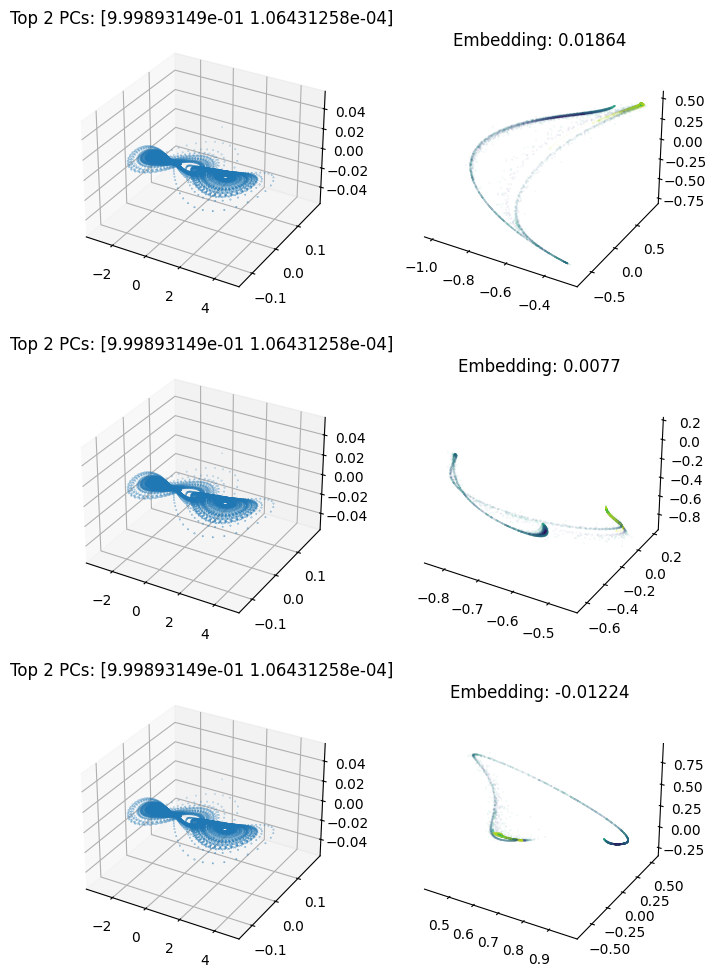

In [88]:
pc_cebra_comp(lorenz_obj,5)

From these figures it looks like the CEBRA embeddings are not in fact consistent for different initializations of models with the same parameters.

In [77]:
# make a pca model and fit on the object
pca_ = PCA(n_components=3)

# compute the PCs and get the explained variance
object_pca = pca_.fit_transform(lorenz_obj)

In [75]:
pca_cebra = cebra.io.reduce(lorenz_obj, num_components=3)

In [78]:
explained_variance_score(lorenz_obj,object_pca)

0.15454463852121494

In [76]:
explained_variance_score(lorenz_obj, pca_cebra)

0.15454463852121292

In [79]:
explained_variance_score(lorenz_obj,ideal_embedding_l)

-0.015581262808562904

In [89]:
a = np.array([0,1,2,23,4,6,7,7,7,8])

In [95]:
kl = [0,1,2,3,4,5]

In [97]:
np.divide(kl,2)

array([0. , 0.5, 1. , 1.5, 2. , 2.5])

In [91]:
np.unique(a, return_counts=True)

(array([ 0,  1,  2,  4,  6,  7,  8, 23]), array([1, 1, 1, 1, 1, 3, 1, 1]))

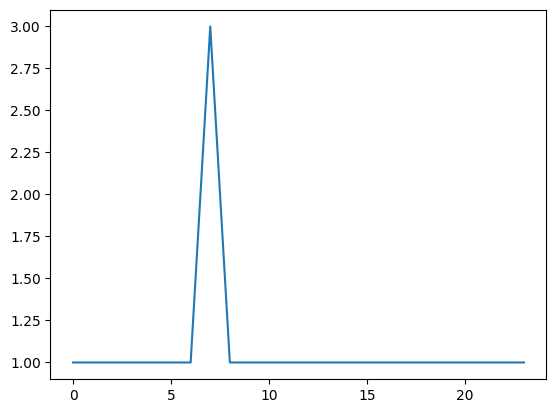

In [93]:
plt.plot(np.unique(a, return_counts=True)[0],np.unique(a, return_counts=True)[1])